In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [57]:
def load_dataset(data_path):
    X = [] # Data (images flattened)
    y = [] # Labels (class ID)
    class_names = []

    if not os.path.exists(data_path):
        print(f"Error: Dataset path '{data_path}' not found!")
        return np.array(X), np.array(y), class_names

    # Explicit order required: 0=dog, 1=panda, 2=cat
    folders = ['dog', 'panda', 'cat']
    class_names = folders

    for label_id, folder in enumerate(folders):
        folder_path = os.path.join(data_path, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder '{folder}' not found. Skipping.")
            continue

        files = os.listdir(folder_path)
        target_count = 100 # Assuming 100 images per class for 300 total

        count = 0
        for file in files:
            if count >= target_count:
                break

            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder_path, file)

                try:
                    img = plt.imread(img_path)
                    gray = to_grayscale(img)
                    resized = resize_image(gray, 32, 32)

                    # Normalize pixel values
                    flat = resized.flatten() / 255.0

                    X.append(flat)
                    y.append(label_id)
                    count += 1
                except Exception as e:
                    print(f"Error reading {file}: {e}")

        print(f"Loaded {count} images for class '{folder}'")

    print(f"Total images loaded: {len(X)}")
    return np.array(X), np.array(y), class_names

In [58]:
import zipfile
import os

zip_path = 'animal_dataset.zip'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Unzipping complete")
else:
    print("Error: upload 'animal_dataset.zip'.")

Unzipping complete


In [59]:
dataset_path = '/content/animal_dataset'
X, y, classes = load_dataset(dataset_path)

Loaded 100 images for class 'dog'
Loaded 100 images for class 'panda'
Loaded 100 images for class 'cat'
Total images loaded: 300


In [60]:
#RGB to Grayscale
def to_grayscale(img):
    if len(img.shape) == 2:
        return img
    return np.dot(img[..., :3], [0.299, 0.587, 0.114])
def resize_image(img, target_h=32, target_w=32):
    h, w = img.shape

    x_indices = np.linspace(0, w-1, target_w).astype(int)
    y_indices = np.linspace(0, h-1, target_h).astype(int)

    resized = img[np.ix_(y_indices, x_indices)]
    return resized

def calculate_distance(p1, p2, method='L2'):
    diff = p1 - p2
    if method == 'L1':
        return np.sum(np.abs(diff))
    else:
        return np.sqrt(np.sum(diff**2))
def knn_predict(X_train, y_train, X_test, k, metric):
    predictions = []

    for test_point in X_test:
        distances = []

        #  Calculate distances
        for i in range(len(X_train)):
            dist = calculate_distance(test_point, X_train[i], metric)
            distances.append((dist, y_train[i]))

        # nearest k
        distances.sort(key=lambda x: x[0])
        k_nearest = distances[:k]
        k_labels = [label for (_, label) in k_nearest]

        most_common = np.bincount(k_labels).argmax()
        predictions.append(most_common)

    return np.array(predictions)


In [74]:
# 1. Shuffle Data
indices = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# 2. Split into 5
folds_X = np.array_split(X, 5)
folds_y = np.array_split(y, 5)

k_values = [1, 3, 5, 7, 9, 11, 13,15,17]

# Lists to store DETAILED results (list of lists)
l1_all_accuracies = []
l2_all_accuracies = []

print("Cross-Validation.")

for k in k_values:
    fold_accuracies_L1 = []
    fold_accuracies_L2 = []

    for i in range(5):
        # Test on fold i, Train on the other 4
        X_val = folds_X[i]
        y_val = folds_y[i]

        # Combine the other for training
        X_train = np.vstack([folds_X[j] for j in range(5) if j != i])
        y_train = np.concatenate([folds_y[j] for j in range(5) if j != i])

        # L1
        preds_L1 = knn_predict(X_train, y_train, X_val, k, 'L1')
        acc_L1 = np.mean(preds_L1 == y_val)
        fold_accuracies_L1.append(acc_L1)

        # L2
        preds_L2 = knn_predict(X_train, y_train, X_val, k, 'L2')
        acc_L2 = np.mean(preds_L2 == y_val)
        fold_accuracies_L2.append(acc_L2)

    # Store full list of 5 scores for k
    l1_all_accuracies.append(fold_accuracies_L1)
    l2_all_accuracies.append(fold_accuracies_L2)

    avg_L1 = np.mean(fold_accuracies_L1)
    avg_L2 = np.mean(fold_accuracies_L2)

    print(f"K={k}:")
    print(f"   L1 Avg = {avg_L1:.4f}")
    print(f"   L2 Avg = {avg_L2:.4f}")



Cross-Validation.
K=1:
   L1 Avg = 0.3767
   L2 Avg = 0.3700
K=3:
   L1 Avg = 0.3700
   L2 Avg = 0.3400
K=5:
   L1 Avg = 0.3667
   L2 Avg = 0.3500
K=7:
   L1 Avg = 0.4133
   L2 Avg = 0.3800
K=9:
   L1 Avg = 0.3967
   L2 Avg = 0.3833
K=11:
   L1 Avg = 0.4133
   L2 Avg = 0.4100
K=13:
   L1 Avg = 0.4367
   L2 Avg = 0.3533
K=15:
   L1 Avg = 0.4300
   L2 Avg = 0.3967
K=17:
   L1 Avg = 0.4067
   L2 Avg = 0.3633


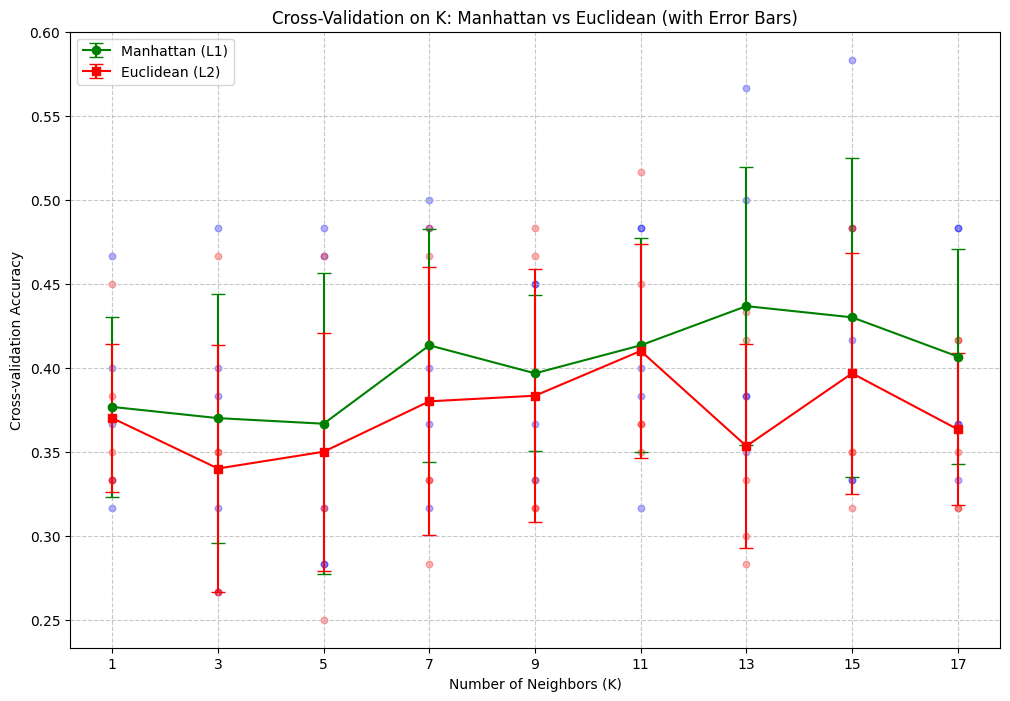


Discussion
Manhattan (L1) performed better with a accuracy of 0.44.


In [75]:
# Means and Standard Deviations for Error Bars
l1_means = [np.mean(acc) for acc in l1_all_accuracies]
l1_stds = [np.std(acc) for acc in l1_all_accuracies]

l2_means = [np.mean(acc) for acc in l2_all_accuracies]
l2_stds = [np.std(acc) for acc in l2_all_accuracies]

plt.figure(figsize=(12, 8))

plt.errorbar(k_values, l1_means, yerr=l1_stds, fmt='-o', label='Manhattan (L1)', color='green', capsize=5)
plt.errorbar(k_values, l2_means, yerr=l2_stds, fmt='-s', label='Euclidean (L2)', color='red', capsize=5)

# 3. Overlay Scatter Points
for i, k in enumerate(k_values):
    # L1 dots (green, transparent)
    plt.scatter([k] * len(l1_all_accuracies[i]), l1_all_accuracies[i], color='blue', alpha=0.3, s=22)
    # L2 dots (Red, transparent)
    plt.scatter([k] * len(l2_all_accuracies[i]), l2_all_accuracies[i], color='red', alpha=0.3, s=22)

plt.title('Cross-Validation on K: Manhattan vs Euclidean (with Error Bars)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-validation Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Discussion
best_l1 = max(l1_means)
best_l2 = max(l2_means)

print("\nDiscussion")
if best_l1 > best_l2:
    print(f"Manhattan (L1) performed better with a accuracy of {best_l1:.2f}.")
else:
    print(f"Euclidean (L2) performed better with a accuracy of {best_l2:.2f}.")

Best Model: Metric=L1, K=13 (Accuracy: 0.4367)
Running predictions on 5 random images using L1


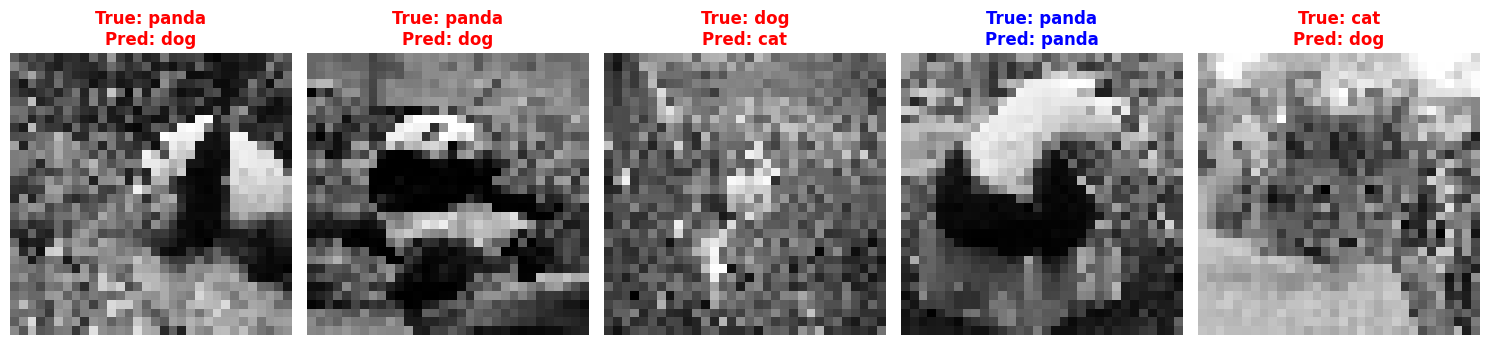

In [78]:
#Auto find best one
# Calculate average accuracy for each K from the above results
l1_means = [np.mean(fold_acc) for fold_acc in l1_all_accuracies]
l2_means = [np.mean(fold_acc) for fold_acc in l2_all_accuracies]

# Find best parameters for L1
best_acc_l1 = max(l1_means)
best_k_l1 = k_values[np.argmax(l1_means)]

# Find best parameters for L2
best_acc_l2 = max(l2_means)
best_k_l2 = k_values[np.argmax(l2_means)]

# Compare L1 and L2
if best_acc_l1 >= best_acc_l2:
    BEST_METRIC = 'L1'
    BEST_K = best_k_l1
    best_acc = best_acc_l1
else:
    BEST_METRIC = 'L2'
    BEST_K = best_k_l2
    best_acc = best_acc_l2

print(f"Best Model: Metric={BEST_METRIC}, K={BEST_K} (Accuracy: {best_acc:.4f})")

# random 5 images
indices = list(range(len(X)))
random.seed(42) #for consistent results
random.shuffle(indices)

test_indices = indices[:5]
train_indices = indices[5:]

X_train_sample = X[train_indices]
y_train_sample = y[train_indices]
X_test_sample = X[test_indices]
y_test_sample = y[test_indices]

print(f"Running predictions on 5 random images using {BEST_METRIC}")
predictions = knn_predict(X_train_sample, y_train_sample, X_test_sample, BEST_K, BEST_METRIC)

plt.figure(figsize=(15, 4))

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)

    # Reshape flat vector back to 32x32 image
    # Multiply by 255 because we normalized it to 0-1 earlier
    img_display = (X_test_sample[i] * 255).reshape(32, 32)

    true_label = classes[y_test_sample[i]]
    pred_label = classes[predictions[i]]

    # Green title if correct, Red if wrong
    color = 'blue' if true_label == pred_label else 'red'

    plt.imshow(img_display, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Discussion**

1.Comparison: Manhattan (L1) vs. Euclidean (L2)
Best one: Manhattan (L1)

Performance: The results from 5-fold cross-validation show that Manhattan (L1) distance consistently achieved higher accuracy than Euclidean (L2) across almost all values of K.

Peak Accuracy: L1 reached a peak average accuracy of 43.67% (at K=13).

Comparison: L2 peaked significantly lower, struggling to surpass 41%. In many cases (like K=13), L1 was ahead by a clear margin.


Why is L1 better for this dataset?

High Dimensionality: Images are flattened into vectors of 1024 numbers (32x32 pixels). In high-dimensional spaces, Euclidean distance (which squares differences) often becomes less effective because the "contrast" between near and far points diminishes. Manhattan distance is generally more robust in these high-dimensional settings.

Nature of Features:  L1 distance treats every pixel difference equally. L2 distance punishes large differences more heavily. In grayscale images, a few pixels might have large brightness shifts due to lighting or shadows, which could confuse the L2 metric. L1 is less sensitive to these outliers.

2.Limitations & Potential Improvements
Limitations:

Low Accuracy (43%): An accuracy of 43% on a 3-class problem is better than random guessing (33%), but still quite poor. This confirms that Raw Pixels are bad features. They are too sensitive to position; if a cat moves 2 pixels to the left, the raw pixel values change completely, confusing the KNN.

Grayscale Loss: Converting to black and white removed color information ( the distinct black/white pattern of a panda vs. a brown dog) making the task harder.


**Potential Improvements:**


Better Features:

Instead of using raw pixels, extract features like HOG (Histogram of Oriented Gradients). HOG focuses on shapes and edges (ears, eyes, snouts) rather than just pixel brightness, making it much better for object recognition.

Use Color:

Keep the RGB channels. The color of the fur is a strong predictor for these specific animals.

Switch Models:

KNN is a very simple algorithm. A Convolutional Neural Network (CNN) is designed specifically for images and would likely achieve 80-90% accuracy on this dataset by learning to recognize patterns automatically.